<>:46: SyntaxWarning: invalid escape sequence '\|'
<>:55: SyntaxWarning: invalid escape sequence '\|'
<>:46: SyntaxWarning: invalid escape sequence '\|'
<>:55: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_24023/2232224221.py:46: SyntaxWarning: invalid escape sequence '\|'
  linestyle='--', label=prefix + '$\|\\alpha\|_0$', axis_position='right', color=color)
/tmp/ipykernel_24023/2232224221.py:55: SyntaxWarning: invalid escape sequence '\|'
  linestyle='--', label=prefix + '$\|\\alpha\|_0$', axis_position='right', color=color)


Canvas(height=600, width=1200)

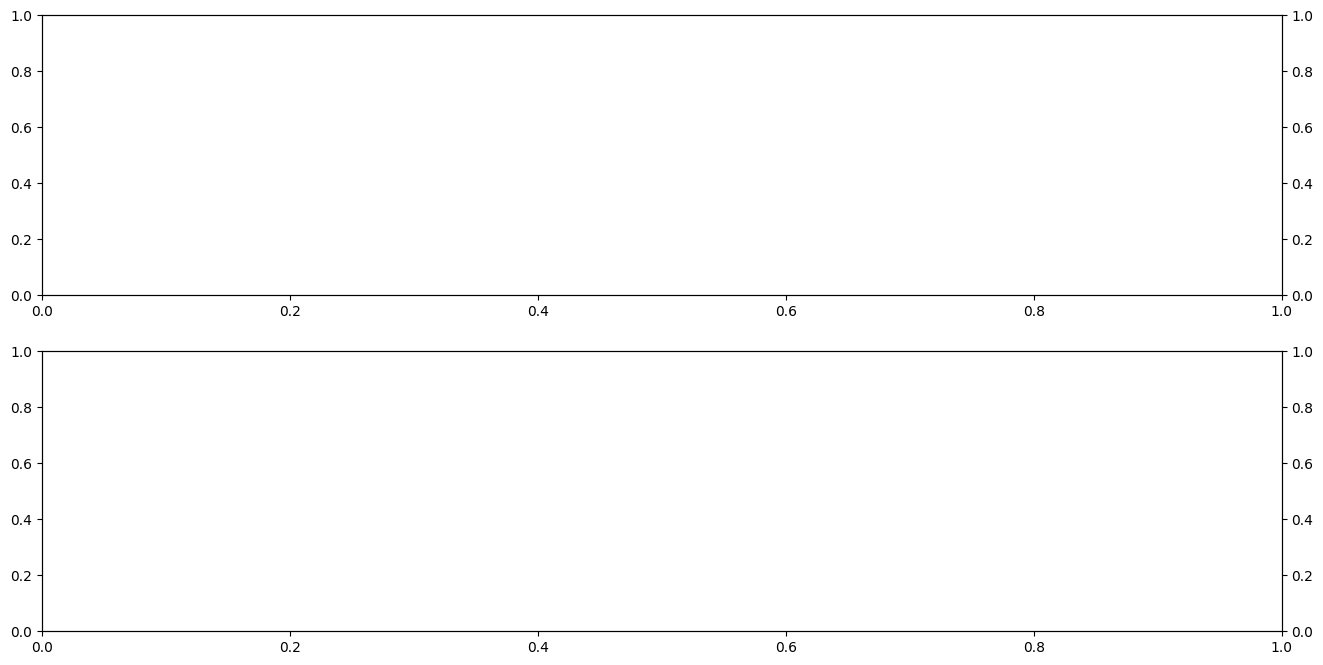

In [1]:
import sys, os, time, copy, functools, numpy, pandas, torch, matplotlib.pyplot, cvxpy

sys.path.append(os.path.abspath(os.path.join('..')))  # Allow repository modules to be imported

from utils.optimization import initialize, train, test, accuracy, get_random_states, set_random_states, extract_samples, ExponentialLoss
from utils.persistance import experiment_exists, load_experiment
from utils.plots import plot_series_and_reference_on_ax, plot_train_loss, draw_figure_into_canvas, save_figure
from utils.models import FullyConnectedNeuralNetwork

train_loss= ExponentialLoss
train_loss_instance = ExponentialLoss()

def model_summary(model, model_metrics, epoch, regularization=0., prefix='', tolerance=1e-5, *args, **kwargs):
    with torch.no_grad():
        norms = model.norms
        count_non_zero_neurons = (norms >= tolerance).count_nonzero().item()

        input_weights = model.input_layer.weight
        if input_weights.grad is not None:
            identity = torch.eye(input_weights.shape[1])
            input_weights_norm = input_weights.norm(dim=1).reshape(-1, 1, 1)
            projection_matrices = identity - ((input_weights.unsqueeze(2) @ input_weights.unsqueeze(1)) / input_weights_norm ** 2)
            changes_in_directions = (projection_matrices @ input_weights.grad.unsqueeze(2) / input_weights_norm ** 2).norm(dim=1).sum().item()

            del identity, input_weights_norm, projection_matrices
        else:
            changes_in_directions = 0

        input_layer_stable_rank = (torch.linalg.matrix_norm(input_weights * norms, ord='fro') / torch.linalg.matrix_norm(input_weights * norms, ord=2)) ** 2        

        metrics_to_add = {'epoch': epoch, 
            prefix + 'changes_in_directions': changes_in_directions,
            prefix + 'count_non_zero_neurons': count_non_zero_neurons,
            prefix + 'input_layer_stable_rank': input_layer_stable_rank
        }
        #if Lambda: metrics_to_add.update({'Lambda': Lambda})
        if regularization: metrics_to_add.update({prefix + 'regularization': regularization})
        model_metrics.append(metrics_to_add)

def plot_count_non_zero_neurons(ax, model_metrics, sample_size, batch_size, color='tab:blue', prefix='', clear_axis=True, *args, **kwargs):
    if clear_axis: ax.clear()
    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size
    model_metrics_df = model_metrics_df[model_metrics_df[prefix + 'count_non_zero_neurons'].notna()]
    plot_series_and_reference_on_ax(ax, model_metrics_df['iterations'].values, model_metrics_df[prefix + 'count_non_zero_neurons'].values, 
                                    linestyle='--', label=prefix + '$\|\\alpha\|_0$', axis_position='right', color=color)
    ax.legend(prop={'size': 16}, loc='upper left')

def plot_stable_rank(ax, model_metrics, sample_size, batch_size, color='tab:blue', prefix='', clear_axis=True, *args, **kwargs):
    if clear_axis: ax.clear()
    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size
    model_metrics_df = model_metrics_df[model_metrics_df[prefix + 'stable_rank'].notna()]
    plot_series_and_reference_on_ax(ax, model_metrics_df['iterations'].values, model_metrics_df[prefix + 'stable_rank'].values, 
                                    linestyle='--', label=prefix + '$\|\\alpha\|_0$', axis_position='right', color=color)
    ax.legend(prop={'size': 16}, loc='upper left')

def plot_changes_in_directions(ax, model_metrics, sample_size, batch_size, color='tab:blue', prefix='', clear_axis=True, *args, **kwargs):
    if clear_axis: ax.clear()
    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size
    model_metrics_df = model_metrics_df[model_metrics_df[prefix + 'changes_in_directions'].notna()]
    ax.plot(model_metrics_df['iterations'].values, model_metrics_df[prefix + 'changes_in_directions'].values, 
            label=prefix + 'changes in directions', linestyle='--', c=color)
    ax.set_yscale('log')
    #plot_series_and_reference_on_ax(ax, model_metrics_df['iterations'].values, model_metrics_df['changes_in_directions'].values, 
    #                                linestyle='--', log_scale=True, label='changes in directions', axis_position='right')
    ax.legend(prop={'size': 16}, loc='upper left')

class MagnitudeOptimizer(torch.nn.Module):

    def __init__(self, backbone, device, *args, **kwargs):
        super(MagnitudeOptimizer, self).__init__()
        for parameter in backbone.parameters(): parameter.requires_grad = False
        self.backbone = backbone
        self.device = device
        classes, backbone_dimention  = backbone.output_layer.weight.shape
        self.output_layer = torch.nn.Linear(backbone_dimention, classes, bias=False)
        with torch.no_grad():
            self.output_layer.weight.copy_(backbone.norms)
            backbone.layers[0].weight.copy_(backbone.layers[0].weight / backbone.layers[0].weight.norm(dim=1).unsqueeze(1))
            backbone.output_layer.weight.copy_(backbone.output_layer.weight / backbone.output_layer.weight.norm(dim=0))

    def forward(self, x):
        self.backbone(x)
        x = self.backbone.activations[-1] * self.backbone.output_layer.weight
        self.activations = [x]
        x = self.output_layer(x).squeeze()
        self.output = x
        self.output.retain_grad()
        return x
    
    @property
    def layers(self):
        return self.backbone.layers
    
    @property
    def dead_units(self):
        return [self.output_layer.weight.squeeze().nonzero().detach().cpu().tolist()]
    
    @property
    def norms(self):
        return self.output_layer.weight.abs().reshape(-1)
    
    @property
    def neurons_sign(self):
        return torch.sign(self.backbone.neurons_sign * self.norms)
    
    @property
    def input_layer(self):
        return self.backbone.input_layer
    

def prune(model, *args, **kwargs):
    neurons_to_prune = (model.output_layer.weight.flatten() < torch.zeros(model.output_layer.weight.shape[1])).nonzero().flatten().cpu().tolist()
    if neurons_to_prune:
        neurons_to_keep = [neuron_index for neuron_index in range(model.output_layer.weight.shape[1]) if neuron_index not in neurons_to_prune]
        new_backbone = FullyConnectedNeuralNetwork(**{**kwargs, 'initial_hidden_units': len(neurons_to_keep)})
        new_output_layer = torch.nn.Linear(len(neurons_to_keep), model.output_layer.weight.shape[0])
        with torch.no_grad():
            new_backbone.layers[0].weight.copy_(model.backbone.layers[0].weight[neurons_to_keep])
            new_backbone.output_layer.weight.copy_(model.backbone.output_layer.weight[:, neurons_to_keep])
            new_output_layer.weight.copy_(model.output_layer.weight[:, neurons_to_keep])

        for parameter in new_backbone.parameters(): 
            parameter.requires_grad = False

        model.backbone = new_backbone
        model.output_layer = new_output_layer
        return True
    
    return False

def execute_experiment(train_data, test_data, model_class, seed:int, epochs:int, learning_rate:float, 
                       regularization:float=0, model=None, train_loss_class=torch.nn.BCEWithLogitsLoss, 
                       saving_epochs_interval=1, callbacks_epochs_interval=0, 
                       train_data_callbacks=None, test_data_callbacks=None, pruning_callback=None,
                       callbacks_epochs=[], callbacks=[], overwrite=False, **experiment):
    experiment.update(dict(seed=seed, epochs=epochs, learning_rate=learning_rate, regularization=regularization))
    device, generator = initialize(seed)
    if model is None:
        if not overwrite and experiment_exists(**experiment):
            experiment = {'epoch': 0, **load_experiment(**experiment), **experiment}
            model = model_class.load(**experiment).to(device)
            generator = set_random_states(**experiment)

        else: 
            model = model_class(**experiment).to(device)

    train_data.generator = test_data.generator = generator
    if regularization > 0:
        class RegularizedLoss(train_loss_class):
            def __call__(self, *args, **kwds):
                return super().__call__(*args, **kwds) + regularization * torch.sum(model.norms)
            
        train_loss_class = RegularizedLoss
    
    train_loss = train_loss_class()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    if 'train_loss' not in experiment:
        experiment.update(dict(epoch=0, train_time=[0], model_metrics=[]))
        experiment.update(dict(test_accuracy=[test(test_data, model, accuracy, device)]))
        experiment.update(dict(train_accuracy=[test(train_data, model, accuracy, device)]))
        experiment.update(dict(test_loss=[test(test_data, model, train_loss, device, callbacks=test_data_callbacks, **experiment)]))
        experiment.update(dict(train_loss=[test(train_data, model, train_loss, device, calculate_gradients=True, retain_graph=True, 
                                                callbacks=train_data_callbacks, **experiment)]))

    else:
        test(test_data, model, train_loss, device, callbacks=test_data_callbacks, **experiment)
        test(train_data, model, train_loss, device, calculate_gradients=True, retain_graph=True, callbacks=train_data_callbacks, **experiment)

    for callback in callbacks: callback(model=model, train_data=train_data, test_data=test_data, **experiment)
    for epoch in range(experiment['epoch'] + 1, epochs + 1):
        start_time = time.time()
        train(train_data, model, train_loss, optimizer, device)
        end_time = time.time()
        train_time = experiment['train_time'][-1] + end_time - start_time
        if pruning_callback:
            model_pruned = pruning_callback(model, train_data=train_data, test_data=test_data, **experiment)
            if model_pruned:
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        experiment['epoch'] = epoch#model.epoch = model.epoch + 1
        experiment['train_time'].append(train_time)
        experiment['test_accuracy'].append(test(test_data, model, accuracy, device))
        experiment['train_accuracy'].append(test(train_data, model, accuracy, device))
        experiment['test_loss'].append(test(test_data, model, train_loss, device, callbacks=test_data_callbacks, **experiment))
        experiment['train_loss'].append(test(train_data, model, train_loss, device, callbacks=train_data_callbacks, 
                                             calculate_gradients=True, retain_graph=True, **experiment))
        experiment['random_states'] = get_random_states()
        
        #if epoch % saving_epochs_interval == 0 or epoch == epochs:
        #    model.save()
        #    save_experiment(experiment)
        
        if (callbacks_epochs_interval and epoch % callbacks_epochs_interval == 0) or epoch in callbacks_epochs or epoch == epochs:
            #experiment['model_metrics'] += model.metrics
            for callback in callbacks: 
                callback(model=model, train_data=train_data, test_data=test_data, **experiment)

    return experiment, model, device, generator

def prune_model_via_magnitude_optimization(model, inputs, labels, regularization, tolerance=1e-14, **experiment):
    signed_labels = (labels * 2. - 1.).unsqueeze(1).detach().cpu().numpy()
    neurons_sign = model.neurons_sign.detach().cpu().numpy()
    neurons_norms = model.norms.detach().cpu().numpy()
    num_neurons = len(neurons_norms)
    
    neurons_normalized_weights = model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1)
    normalized_predictions = neurons_sign * torch.relu(inputs @ neurons_normalized_weights.T).detach().cpu().numpy()
    normalized_margins = signed_labels * normalized_predictions
    new_model = FullyConnectedNeuralNetwork(**experiment)
    with torch.no_grad():
        new_model.input_layer.weight.copy_(model.input_layer.weight)
        new_model.output_layer.weight.copy_(model.output_layer.weight)

    new_model = MagnitudeOptimizer(new_model, new_model.device)
    alpha = cvxpy.Variable(num_neurons, nonneg=True)
    alpha.value = neurons_norms
    objective = cvxpy.Minimize(cvxpy.sum(cvxpy.exp(- normalized_margins @ alpha)) / experiment['sample_size'] + regularization * cvxpy.norm(alpha, 1))
    problem = cvxpy.Problem(objective)
    _ = problem.solve(warm_start=True,
        tol_gap_abs=tolerance,
        tol_gap_rel=tolerance,
        tol_feas=tolerance,
        tol_infeas_abs=tolerance,
        tol_infeas_rel=tolerance,
        tol_ktratio=tolerance,
    )
    alpha_star = numpy.where(alpha.value >= tolerance, alpha.value, 0.)
    with torch.no_grad():
        new_model.output_layer.weight.copy_(torch.tensor(alpha_star))

    return new_model

def plot_pruned_model_loss(ax, model_metrics, sample_size, batch_size, prefix='', *args, **kwargs):
    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size
    model_metrics_df = model_metrics_df[model_metrics_df[prefix + 'train_loss'].notna()]
    ax.plot(model_metrics_df['iterations'].values, model_metrics_df[prefix + 'train_loss'].values, 
            label=prefix + 'train_loss', c='tab:green')
    
    ax.plot(model_metrics_df['iterations'].values, model_metrics_df[prefix + 'test_loss'].values, 
            label=prefix + 'test_loss', c='tab:orange')
    
    ax.set_yscale('log')
    ax.legend(prop={'size': 16})


class Growing2LayerReLUNN(torch.nn.Module):

    def __init__(self, input_dimention, backbone, bias=True, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        self.input_dimention = input_dimention
        self.backbone = backbone
        self.n_neurons = 0
        self.n_observed_classes = 0
        self.bias = bias

    def forward(self, x):
        x = self.backbone(x)
        self.activations = torch.relu(self.input_layer(x))
        return self.output_layer(self.activations)
    
    @property
    def parameters(self):
        return list(self.input_layer.parameters()) + list(self.output_layer.parameters())

    def _recreate_network(self, n_neurons, n_classes):
        self.input_layer = torch.nn.Linear(in_features=self.input_dimention, out_features=n_neurons, bias=self.bias)
        self.output_layer = torch.nn.Linear(in_features=n_neurons, out_features=n_classes, bias=self.bias)
 
    def increase_width(self, n_new_classes, n_new_neurons):
        self.n_observed_classes += n_new_classes
        self.n_neurons += n_new_neurons
        
        previous_input_layer = self.input_layer
        previous_output_layer = self.output_layer
        
        self._recreate_network(self.n_neurons, self.n_observed_classes)
        
        if previous_input_layer is not None:
            with torch.no_grad():
                self.input_layer.weight[:-n_new_neurons].copy_(previous_input_layer.weight.data.clone())
                self.output_layer.weight[:-n_new_neurons].copy_(previous_output_layer.weight.data.clone())
    
    @property
    def norms(self):
        return self.input_layer.weight.norm() * self.output_layer.weight.T.norm()

    def prune(self, inputs, labels, regularization, threshold=1e-5, cvxpy_tolerance=1e-14):
        signed_labels = (labels * 2. - 1.).unsqueeze(1).detach().cpu().numpy()
        neurons_norms = self.norms.detach().cpu().numpy()
        neurons_normalized_input_weights = self.input_layer.weight / self.input_layer.weight.norm(dim=1, keepdim=True)
        neurons_normalized_output_weights = self.output_layer.weight.T / self.output_layer.weight.T.norm(dim=1, keepdim=True)
        normalized_predictions = (neurons_normalized_output_weights @ torch.relu(inputs @ neurons_normalized_input_weights.T)).detach().cpu().numpy()
        normalized_margins = signed_labels * normalized_predictions
        num_neurons = len(neurons_norms)
        alpha = cvxpy.Variable(num_neurons, nonneg=True)
        alpha.value = neurons_norms
        objective = cvxpy.Minimize(cvxpy.sum(cvxpy.exp(- normalized_margins @ alpha)) / len(inputs) + regularization * cvxpy.norm(alpha, 1))
        cvxpy.Problem(objective).solve(warm_start=True,
            tol_gap_abs=cvxpy_tolerance,
            tol_gap_rel=cvxpy_tolerance,
            tol_feas=cvxpy_tolerance,
            tol_infeas_abs=cvxpy_tolerance,
            tol_infeas_rel=cvxpy_tolerance,
            tol_ktratio=cvxpy_tolerance,
        )
        optimal_magnitudes = torch.tensor(numpy.where(alpha.value >= threshold, alpha.value, 0.))
        nonzero_neurons_indices = optimal_magnitudes.nonzero()[0].flatten()
        self._recreate_network(len(nonzero_neurons_indices), self.observed_classes)
        with torch.no_grad(): 
            self.input_layer.weight.copy_(neurons_normalized_input_weights[nonzero_neurons_indices] * optimal_magnitudes ** 0.5)
            self.output_layer.weight.copy_((neurons_normalized_output_weights[:, nonzero_neurons_indices] * optimal_magnitudes ** 0.5).T)
            

import ipycanvas, matplotlib.pyplot
matplotlib.pyplot.ioff()

figure, (loss_ax, l0_ax) = matplotlib.pyplot.subplots(2, 1, figsize=(16, 8))

directions_ax = loss_ax.twinx()
stable_rank_ax = l0_ax.twinx()

def plot_pruned_model(model, inputs, train_data, test_data, epoch, model_metrics, magnitude_optimization_regularization, **kwargs):
    pruned_model = prune_model_via_magnitude_optimization(model, inputs=inputs, epoch=epoch, **{**kwargs, 'regularization': magnitude_optimization_regularization})
    pruned_model_predictions = pruned_model(inputs)
    prefix = 'pruned '
    model_metrics.append({
        'epoch': epoch,
        prefix + 'train_loss': test(train_data, pruned_model, train_loss_instance, model.device, **kwargs),
        prefix + 'test_loss': test(test_data, pruned_model, train_loss_instance, model.device, **kwargs)                    
    })
    args = {**kwargs, 'model': pruned_model, 'inputs': inputs, 'predictions': pruned_model_predictions, 'model_metrics': model_metrics, 'epoch': epoch, 'prefix': prefix,
            'regularization': magnitude_optimization_regularization}
    
    model_summary(**args)
    plot_changes_in_directions(directions_ax, color='tab:orange', clear_axis=False, **args)
    plot_count_non_zero_neurons(l0_ax, color='tab:orange', clear_axis=False, **args)
    plot_stable_rank(stable_rank_ax, color='tab:orange', **args)
    plot_pruned_model_loss(loss_ax, **args)

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1200, 600
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)
canvas

# 2 layer ReLU NN

In [3]:
import gc, torchvision.transforms, torchvision, timm

backbone = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
backbone.out_dim = 768
backbone = backbone.eval()

input_size = 224
scale = (0.05, 1.0)
ratio = (3. / 4., 4. / 3.)

train_data = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./data/imagenet-a/train', transform=torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(input_size, scale=scale, ratio=ratio),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
])), shuffle=True)

inputs = [backbone(image) for image, _ in train_data]
labels = train_data.targets

del train_data
gc.collect()
batch_size = sample_size = len(inputs)
train_data = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(inputs), torch.Tensor(labels)), batch_size)

test_data = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./data/imagenet-a/test', transform=torchvision.transforms.ToTensor()), shuffle=False)
test_inputs = [backbone(image) for image, _ in test_data]
test_labels = test_data.targets
del test_data
gc.collect()

test_data = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(test_inputs), torch.Tensor(test_labels)))

: 

In [ ]:
experiment = {
    'seed': 3,
    'input_dimension': 768, 
    'n_new_classes': 5,
    'n_new_neurons': 1000,
    'epochs_per_task': 1000,
    'learning_rate': .1,
    'bias': True,
    'initialization_scale': 1.e-5,
    'initial_hidden_units': 200,
    'name_parameters': ['id'],
    'id': 'imagenet_a-magnitude_optimization',
    'magnitude_optimization_regularization': 0.001
}
train_loss = ExponentialLoss
inputs, labels = extract_samples(train_data)
model_summary_ = functools.partial(model_summary, inputs=inputs)
plot_train_loss_ = functools.partial(plot_train_loss, ax=loss_ax, legend_loc='upper right')
plot_changes_in_directions_ = functools.partial(plot_changes_in_directions, ax=directions_ax, legend_loc='upper left')
plot_count_non_zero_neurons_ = functools.partial(plot_count_non_zero_neurons, ax=l0_ax, legend_loc='upper left')
plot_stable_rank_ = functools.partial(plot_stable_rank, ax=stable_rank_ax, legend_loc='upper left')
draw_figure_into_canvas_ = functools.partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure_ = functools.partial(save_figure, figure=figure, parameters=experiment, **experiment)

experiment_stage1_result, model, device, generator = execute_experiment(
    **experiment, #**{**experiment, 'id': 'unregularized'},
    train_data=train_data, 
    test_data=test_data, 
    model_class=FullyConnectedNeuralNetwork,
    train_loss_class=train_loss,
    callbacks_epochs=list(range(0, experiment['epochs'], experiment['epochs'])),
    overwrite=True,
    callbacks=[
            plot_changes_in_directions_,
            plot_stable_rank_,
            plot_count_non_zero_neurons_,
            plot_train_loss_,
            draw_figure_into_canvas_, 
            save_figure_
    ],
    train_data_callbacks=[model_summary_]
)

# Even vs Odd MNIST

In [6]:
from settings.even_vs_odd_mnist import train_dataloader, test_dataloader, HEIGHT, WIDTH, TRAIN_SAMPLES

#regularization_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]#numpy.logspace(-12, 4, num=1000)
experiment = {
    'seed': 3,
    'input_dimension': HEIGHT * WIDTH, 
    'classes': 2,
    'sample_size': TRAIN_SAMPLES,  
    'batch_size': TRAIN_SAMPLES, 
    'epochs': 1000,
    'learning_rate': .1,
    'bias': True,
    'initialization_scale': 1.e-5,
    'initial_hidden_units': 200,
    'name_parameters': ['id'],
    'id': 'even_vs_odd_mnist',
    'magnitude_optimization_regularization': 0.001
}
train_loss = ExponentialLoss
train_data, test_data = train_dataloader(), test_dataloader()
inputs, labels = extract_samples(train_data)
model_summary_ = functools.partial(model_summary, inputs=inputs)
plot_train_loss_ = functools.partial(plot_train_loss, ax=loss_ax, legend_loc='upper right')
plot_changes_in_directions_ = functools.partial(plot_changes_in_directions, ax=directions_ax, legend_loc='upper left')
plot_count_non_zero_neurons_ = functools.partial(plot_count_non_zero_neurons, ax=l0_ax, legend_loc='upper left')
plot_stable_rank_ = functools.partial(plot_stable_rank, ax=stable_rank_ax, legend_loc='upper left')
draw_figure_into_canvas_ = functools.partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure_ = functools.partial(save_figure, figure=figure, parameters=experiment, **experiment)

experiment_stage1_result, model, device, generator = execute_experiment(
    **experiment, #**{**experiment, 'id': 'unregularized'},
    train_data=train_data, 
    test_data=test_data, 
    model_class=FullyConnectedNeuralNetwork,
    train_loss_class=train_loss,
    callbacks_epochs=list(range(0, experiment['epochs'], experiment['epochs'])),
    overwrite=True,
    callbacks=[
            plot_changes_in_directions_,
            plot_stable_rank_,
            plot_count_non_zero_neurons_,
            plot_train_loss_,
            draw_figure_into_canvas_, 
            save_figure_
    ],
    train_data_callbacks=[model_summary_]
)

/workspaces/adaptive_size_networks/notebooks/utils/models.py:138: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  return (weights_products.T * self.output_layer.weight.norm(dim=0)).reshape(-1)


: 

In [ ]:

signed_labels = (labels * 2. - 1.).unsqueeze(1).detach().cpu().numpy()
neurons_norms = model.norms.detach().cpu().numpy()
neurons_normalized_weights = model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1)
neurons_sign = model.neurons_sign.detach().cpu().numpy()
normalized_predictions = neurons_sign * torch.relu(inputs @ neurons_normalized_weights.T).detach().cpu().numpy()
normalized_margins = signed_labels * normalized_predictions
num_neurons = len(neurons_norms)
new_model = FullyConnectedNeuralNetwork(**experiment)
with torch.no_grad():
    new_model.input_layer.weight.copy_(model.input_layer.weight)
    new_model.output_layer.weight.copy_(model.output_layer.weight)

new_model = MagnitudeOptimizer(new_model, new_model.device)
train_loss_instance = train_loss()
magnitude_optimizations_results = []
for regularization in tqdm.tqdm(regularization_values):
    # Construct the problem.
    alpha = cvxpy.Variable(num_neurons, nonneg=True)
    alpha.value = neurons_norms
    objective = cvxpy.Minimize(cvxpy.sum(cvxpy.exp(- normalized_margins @ alpha)) / experiment['sample_size'] + regularization * cvxpy.norm(alpha, 1))
    problem = cvxpy.Problem(objective)

    # The optimal objective value is returned by `prob.solve()`.
    result = problem.solve(warm_start=True,
        tol_gap_abs=1e-14,
        tol_gap_rel=1e-14,
        tol_feas=1e-14,
        tol_infeas_abs=1e-14,
        tol_infeas_rel=1e-14,
        tol_ktratio=1e-14,
    )
        
    # The optimal value for x is stored in `x.value`.
    #print(alpha.value)
    #print(problem.status)
    alpha_star = numpy.where(alpha.value >= 1e-14, alpha.value, 0.) # projection operator

    with torch.no_grad():
        new_model.output_layer.weight.copy_(torch.tensor(alpha_star))

    predictions = new_model(inputs)
    experiment_stage2 = {**copy.deepcopy(experiment_stage1_result), 'epoch': 1001, 'id': 'regularized', 'regularization': regularization}
    for callback in [
        model_summary_,
        plot_changes_in_directions_,
        #plot_unique_neuron_angles_,
        #plot_weights_norms_, 
        plot_loss_gradient_inner_product_to_norm_ratio_,
        lambda test_data, model, **experiment: experiment_stage2['test_loss'].append(test(test_data, model, train_loss_instance, model.device, **experiment)),
        lambda train_data, model, **experiment: experiment_stage2['train_loss'].append(test(train_data, model, train_loss_instance, model.device, **experiment)),
        plot_train_loss_,
        draw_figure_into_canvas_,
        save_figure_
    ]:
        callback(model=new_model, train_data=train_data, test_data=test_data, labels=labels, predictions=predictions, **experiment_stage2)

    magnitude_optimizations_results.append(experiment_stage2['model_metrics'][-1])

In [ ]:
import numpy, torch



In [7]:
import torch.utils
import torch.utils.data
import os, sys, numpy, copy, tqdm, cvxpy

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from utils.optimization import extract_samples, ExponentialLoss
from utils.plots import plot_train_loss, draw_figure_into_canvas, save_figure
from utils.models import FullyConnectedNeuralNetwork
from settings.even_vs_odd_mnist import train_dataloader, test_dataloader, HEIGHT, WIDTH, TRAIN_SAMPLES

regularization_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]#numpy.logspace(-12, 4, num=1000)
experiment = {
    'seed': 3,
    'input_dimension': HEIGHT * WIDTH, 
    'classes': 2,
    'sample_size': TRAIN_SAMPLES,  
    'batch_size': TRAIN_SAMPLES, 
    'epochs': 1000,
    'learning_rate': .1,
    'bias': True,
    'initialization_scale': 1.e-10,
    'initial_hidden_units': 200,
    'name_parameters': ['id']
}
train_loss = ExponentialLoss
train_data, test_data = train_dataloader(), test_dataloader()
inputs, labels = extract_samples(train_data)
model_summary_ = functools.partial(model_summary, inputs=inputs)
plot_train_loss_ = functools.partial(plot_train_loss, ax=loss_ax, legend_loc='upper right')
plot_changes_in_directions_ = functools.partial(plot_changes_in_directions, ax=directions_ax, legend_loc='upper left')
plot_loss_gradient_inner_product_to_norm_ratio_ = functools.partial(plot_loss_gradient_inner_product_to_norm_ratio, ax=loss_gradient_inner_product_to_norm_ratio_ax, aggregate_neurons=True)
plot_stable_rank_ = functools.partial(plot_stable_rank, ax=stable_rank_ax, legend_loc='upper left')
draw_figure_into_canvas_ = functools.partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure_ = functools.partial(save_figure, figure=figure, parameters=experiment, **experiment)

experiment_stage1_result, model, device, generator = execute_experiment(
    **{**experiment, 'id': 'unregularized'},
    train_data=train_data, 
    test_data=test_data, 
    model_class=FullyConnectedNeuralNetwork,
    train_loss_class=train_loss,
    callbacks_epochs=list(range(0, experiment['epochs'], experiment['epochs'])),
    overwrite=True,
    callbacks=[
            plot_changes_in_directions_,
            #plot_weights_norms_, 
            plot_train_loss_,
            plot_loss_gradient_inner_product_to_norm_ratio_,
            draw_figure_into_canvas_, 
            save_figure_
    ],
    train_data_callbacks=[model_summary_]
)
signed_labels = (labels * 2. - 1.).unsqueeze(1).detach().cpu().numpy()
neurons_norms = model.norms.detach().cpu().numpy()
neurons_normalized_weights = model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1)
neurons_sign = model.neurons_sign.detach().cpu().numpy()
normalized_predictions = neurons_sign * torch.relu(inputs @ neurons_normalized_weights.T).detach().cpu().numpy()
normalized_margins = signed_labels * normalized_predictions
num_neurons = len(neurons_norms)
new_model = FullyConnectedNeuralNetwork(**experiment)
with torch.no_grad():
    new_model.input_layer.weight.copy_(model.input_layer.weight)
    new_model.output_layer.weight.copy_(model.output_layer.weight)

new_model = MagnitudeOptimizer(new_model, new_model.device)
train_loss_instance = train_loss()
magnitude_optimizations_results = []
for regularization in tqdm.tqdm(regularization_values):
    # Construct the problem.
    alpha = cvxpy.Variable(num_neurons, nonneg=True)
    alpha.value = neurons_norms
    objective = cvxpy.Minimize(cvxpy.sum(cvxpy.exp(- normalized_margins @ alpha)) / experiment['sample_size'] + regularization * cvxpy.norm(alpha, 1))
    problem = cvxpy.Problem(objective)

    # The optimal objective value is returned by `prob.solve()`.
    result = problem.solve(warm_start=True,
        tol_gap_abs=1e-14,
        tol_gap_rel=1e-14,
        tol_feas=1e-14,
        tol_infeas_abs=1e-14,
        tol_infeas_rel=1e-14,
        tol_ktratio=1e-14,
    )
        
    # The optimal value for x is stored in `x.value`.
    #print(alpha.value)
    #print(problem.status)
    alpha_star = numpy.where(alpha.value >= 1e-14, alpha.value, 0.) # projection operator

    with torch.no_grad():
        new_model.output_layer.weight.copy_(torch.tensor(alpha_star))

    predictions = new_model(inputs)
    experiment_stage2 = {**copy.deepcopy(experiment_stage1_result), 'epoch': 1001, 'id': 'regularized', 'regularization': regularization}
    for callback in [
        model_summary_,
        plot_changes_in_directions_,
        #plot_unique_neuron_angles_,
        #plot_weights_norms_, 
        plot_loss_gradient_inner_product_to_norm_ratio_,
        lambda test_data, model, **experiment: experiment_stage2['test_loss'].append(test(test_data, model, train_loss_instance, model.device, **experiment)),
        lambda train_data, model, **experiment: experiment_stage2['train_loss'].append(test(train_data, model, train_loss_instance, model.device, **experiment)),
        plot_train_loss_,
        draw_figure_into_canvas_,
        save_figure_
    ]:
        callback(model=new_model, train_data=train_data, test_data=test_data, labels=labels, predictions=predictions, **experiment_stage2)

    magnitude_optimizations_results.append(experiment_stage2['model_metrics'][-1])

: 

# Legacy

In [ ]:
import sys, os, time, pandas, torch, matplotlib.pyplot, functools

sys.path.append(os.path.abspath(os.path.join('..')))  # Allow repository modules to be imported

from settings.even_vs_odd_mnist import train_dataloader, HEIGHT, WIDTH

dataloader = train_dataloader(batch_size=128)
for image, label in dataloader:
    break

fig, (ax, ax2) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 8))
ax.imshow(image[0].reshape(WIDTH, HEIGHT), cmap='gray')
ax.set_title(f'label: {label[0]}')
ax2.imshow(image[1].reshape(WIDTH, HEIGHT), cmap='gray')
ax2.set_title(f'label: {label[1]}')

# Solution of the max margin problem

In [2]:
import torch.utils
import torch.utils.data
import os, sys, numpy, copy, tqdm, cvxpy

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from utils.optimization import initialize, extract_samples, ExponentialLoss
from utils.plots import plot_train_loss, plot_samples_and_neurons, draw_figure_into_canvas, save_figure
from utils.models import FullyConnectedNeuralNetwork
from settings.sphere_2d_epsilon_net import get_clusters_means_and_labels
from settings.gaussian_clusters import get_dataloader

#regularization_values = numpy.logspace(-12, 4, num=1000)    # [0.001]
regularization_values = [0.0001]
variances = [0.]#numpy.logspace(-5, 0, 6)
variances_results = []
for within_cluster_variance in tqdm.tqdm(variances):
    experiment = {
        'epsilon': .8,
        'seed': 3,
        'input_dimension': 2, 
        'classes': 2,
        'sample_size': 100,  
        'batch_size': 100, 
        'epochs': 1000,
        'learning_rate': .1,
        'bias': False,
        #'initialization_scale': 1.e-10,
        'initial_hidden_units': 1,
        'within_cluster_variance': within_cluster_variance,
        'name_parameters': ['id'],
        'initial_weights': [
            [[(1e-5)**.5, (1e-5)**.5]]
        ],
        'output_layer_initial_weights': [1e-5]
    }
    train_loss = ExponentialLoss
    rotation_matrix = numpy.identity(experiment['input_dimension'])
    device, generator = initialize(experiment['seed'])
    clusters_means, clusters_labels = get_clusters_means_and_labels(**experiment)
    inputs_ =[
        [0, 1.],
        [1., -1e-5]
    ]
    labels_ = [1, 1]
    dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(inputs_), torch.Tensor(labels_)), experiment['batch_size'], generator=generator)
    train_data = dataloader
    test_data = dataloader
    #train_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
    #                            rotation_matrix=rotation_matrix, generator=generator)
    #test_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
    #                            rotation_matrix=rotation_matrix, generator=generator)
    inputs, labels = extract_samples(train_data)

    model_summary_ = functools.partial(model_summary, inputs=inputs)
    plot_samples_and_neurons_ = functools.partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
    plot_angle_linesearch_ = functools.partial(plot_angle_linesearch, ax_inner_products=inner_products_ax, ax_neurons=neurons_ax, inputs=inputs, labels=labels)
    plot_train_loss_ = functools.partial(plot_train_loss, ax=loss_ax, legend_loc='upper right')
    plot_changes_in_directions_ = functools.partial(plot_changes_in_directions, ax=directions_ax, legend_loc='upper left')
    plot_loss_gradient_inner_product_to_norm_ratio_ = functools.partial(plot_loss_gradient_inner_product_to_norm_ratio, ax=loss_gradient_inner_product_to_norm_ratio_ax, aggregate_neurons=True)
    draw_figure_into_canvas_ = functools.partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
    save_figure_ = functools.partial(save_figure, figure=figure, parameters=experiment, **experiment)

    experiment_stage1_result, model, device, generator = execute_experiment(
        **{**experiment, 'id': 'max_margin_solution_unregularized'},
        train_data=train_data, 
        test_data=test_data, 
        model_class=FullyConnectedNeuralNetwork,
        train_loss_class=train_loss,
        callbacks_epochs=list(range(0, experiment['epochs'], experiment['epochs'])),
        overwrite=True,
        callbacks=[
                lambda *args, **kwargs: figure.suptitle(f'$\\sigma$ = {within_cluster_variance:.0e}', fontsize=16),
                plot_angle_linesearch_, 
                plot_changes_in_directions_,
                #plot_weights_norms_, 
                plot_train_loss_,
                plot_loss_gradient_inner_product_to_norm_ratio_,
                #plot_unique_neuron_angles_,
                plot_samples_and_neurons_,
                draw_figure_into_canvas_, 
                save_figure_
        ],
        train_data_callbacks=[model_summary_]
    )
    signed_labels = (labels * 2. - 1.).unsqueeze(1).detach().cpu().numpy()
    #predictions = model(inputs)
    neurons_norms = model.norms.detach().cpu().numpy()
    neurons_normalized_weights = model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1)
    neurons_sign = model.neurons_sign.detach().cpu().numpy()
    normalized_predictions = neurons_sign * torch.relu(inputs @ neurons_normalized_weights.T).detach().cpu().numpy()
    normalized_margins = signed_labels * normalized_predictions
    num_neurons = len(neurons_norms)
    new_model = FullyConnectedNeuralNetwork(**experiment)
    with torch.no_grad():
        new_model.input_layer.weight.copy_(model.input_layer.weight)
        new_model.output_layer.weight.copy_(model.output_layer.weight)

    new_model = MagnitudeOptimizer(new_model, new_model.device)
    train_loss_instance = train_loss()
    magnitude_optimizations_results = []
    for regularization in tqdm.tqdm(regularization_values):
        # Construct the problem.
        alpha = cvxpy.Variable(num_neurons, nonneg=True)
        alpha.value = neurons_norms
        objective = cvxpy.Minimize(cvxpy.sum(cvxpy.exp(- normalized_margins @ alpha)) / experiment['sample_size'] + regularization * cvxpy.norm(alpha, 1))
        problem = cvxpy.Problem(objective)

        # The optimal objective value is returned by `prob.solve()`.
        result = problem.solve(warm_start=True,
            tol_gap_abs=1e-14,
            tol_gap_rel=1e-14,
            tol_feas=1e-14,
            tol_infeas_abs=1e-14,
            tol_infeas_rel=1e-14,
            tol_ktratio=1e-14,
        )
            
        # The optimal value for x is stored in `x.value`.
        #print(alpha.value)
        #print(problem.status)
        alpha_star = numpy.where(alpha.value >= 1e-14, alpha.value, 0.) # projection operator

        with torch.no_grad():
            new_model.output_layer.weight.copy_(torch.tensor(alpha_star))

        predictions = new_model(inputs)
        #margins = signed_labels * predictions
        #signed_labels * torch.exp(-margins) * (inputs @ )
        #with torch.no_grad():
        #    new_model.output_layer.weight.copy_(torch.tensor(alpha.value))
        experiment_stage2 = {**copy.deepcopy(experiment_stage1_result), 'epoch': 1001, 'id': 'max_margin_solution_regularized', 'regularization': regularization, 'name_parameters': ['id']}
        for callback in [
            model_summary_,
            plot_angle_linesearch_, 
            plot_changes_in_directions_,
            #plot_unique_neuron_angles_,
            #plot_weights_norms_, 
            plot_loss_gradient_inner_product_to_norm_ratio_,
            plot_samples_and_neurons_,
            lambda test_data, model, **experiment: experiment_stage2['test_loss'].append(test(test_data, model, train_loss_instance, model.device, **experiment)),
            lambda train_data, model, **experiment: experiment_stage2['train_loss'].append(test(train_data, model, train_loss_instance, model.device, **experiment)),
            plot_train_loss_,
            draw_figure_into_canvas_,
            save_figure_
        ]:
            callback(model=new_model, train_data=train_data, test_data=test_data, labels=labels, predictions=predictions, **experiment_stage2)

        magnitude_optimizations_results.append(experiment_stage2['model_metrics'][-1])

    variances_results.append(magnitude_optimizations_results)

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_11646/4075682576.py:56: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  loss_gradient_inner_product_to_norm_ratio_std = normalized_inner_products.std().item()
/workspaces/adaptive_size_networks/notebooks/utils/models.py:138: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return (weights_products.T * self.output_layer.weight.norm(dim=0)).reshape(-1)
/tmp/ipykernel_11646/4075682576.py:92: UserWarning: std(): degrees of freedom is <= 0. Correction should be 

# Combination of max margin solution and KKT points

In [12]:
import torch.utils
import torch.utils.data
import os, sys, numpy, copy, tqdm, cvxpy

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from utils.optimization import initialize, extract_samples, ExponentialLoss
from utils.plots import plot_train_loss, plot_samples_and_neurons, draw_figure_into_canvas, save_figure
from utils.models import FullyConnectedNeuralNetwork
from settings.sphere_2d_epsilon_net import get_clusters_means_and_labels
from settings.gaussian_clusters import get_dataloader

#regularization_values = numpy.logspace(-12, 4, num=1000)    # [0.001]
regularization_values = [0.0001]
variances = [0.]#numpy.logspace(-5, 0, 6)
variances_results = []
for within_cluster_variance in tqdm.tqdm(variances):
    experiment = {
        'epsilon': .8,
        'seed': 3,
        'input_dimension': 2, 
        'classes': 2,
        'sample_size': 100,  
        'batch_size': 100, 
        'epochs': 1000,
        'learning_rate': .1,
        'bias': False,
        #'initialization_scale': 1.e-10,
        'initial_hidden_units': 3,
        'within_cluster_variance': within_cluster_variance,
        'name_parameters': ['id'],
        #'initial_weights': [[0., 1.], [-1., 0.], [1., 0.]],
        'initial_weights': [
            [[0., 1e-5], [1e-5, -1e-10], [(1e-5)**.5, (1e-5)**.5]]
        ],
        'output_layer_initial_weights': [1e-5, 1e-5, 1e-5]
    }
    train_loss = ExponentialLoss
    rotation_matrix = numpy.identity(experiment['input_dimension'])
    device, generator = initialize(experiment['seed'])
    clusters_means, clusters_labels = get_clusters_means_and_labels(**experiment)
    inputs_ =[
        [0, 1.],
        [1., -1e-5]
    ]
    labels_ = [1, 1]
    dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(inputs_), torch.Tensor(labels_)), experiment['batch_size'], generator=generator)
    train_data = dataloader
    test_data = dataloader
    #train_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
    #                            rotation_matrix=rotation_matrix, generator=generator)
    #test_data = get_dataloader(**experiment, clusters_means=clusters_means, clusters_labels=clusters_labels, 
    #                            rotation_matrix=rotation_matrix, generator=generator)
    inputs, labels = extract_samples(train_data)

    model_summary_ = functools.partial(model_summary, inputs=inputs)
    plot_samples_and_neurons_ = functools.partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
    plot_angle_linesearch_ = functools.partial(plot_angle_linesearch, ax_inner_products=inner_products_ax, ax_neurons=neurons_ax, inputs=inputs, labels=labels)
    plot_train_loss_ = functools.partial(plot_train_loss, ax=loss_ax, legend_loc='upper right')
    plot_changes_in_directions_ = functools.partial(plot_changes_in_directions, ax=directions_ax, legend_loc='upper left')
    plot_loss_gradient_inner_product_to_norm_ratio_ = functools.partial(plot_loss_gradient_inner_product_to_norm_ratio, ax=loss_gradient_inner_product_to_norm_ratio_ax, aggregate_neurons=True)
    draw_figure_into_canvas_ = functools.partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
    save_figure_ = functools.partial(save_figure, figure=figure, parameters=experiment, **experiment)

    experiment_stage1_result, model, device, generator = execute_experiment(
        **{**experiment, 'id': 'combination_unregularized'},
        train_data=train_data, 
        test_data=test_data, 
        model_class=FullyConnectedNeuralNetwork,
        train_loss_class=train_loss,
        callbacks_epochs=list(range(0, experiment['epochs'], experiment['epochs'])),
        overwrite=True,
        callbacks=[
                lambda *args, **kwargs: figure.suptitle(f'$\\sigma$ = {within_cluster_variance:.0e}', fontsize=16),
                plot_angle_linesearch_, 
                plot_changes_in_directions_,
                #plot_weights_norms_, 
                plot_train_loss_,
                plot_loss_gradient_inner_product_to_norm_ratio_,
                #plot_unique_neuron_angles_,
                plot_samples_and_neurons_,
                draw_figure_into_canvas_, 
                save_figure_
        ],
        train_data_callbacks=[model_summary_]
    )
    signed_labels = (labels * 2. - 1.).unsqueeze(1).detach().cpu().numpy()
    #predictions = model(inputs)
    neurons_norms = model.norms.detach().cpu().numpy()
    neurons_normalized_weights = model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1)
    neurons_sign = model.neurons_sign.detach().cpu().numpy()
    normalized_predictions = neurons_sign * torch.relu(inputs @ neurons_normalized_weights.T).detach().cpu().numpy()
    normalized_margins = signed_labels * normalized_predictions
    num_neurons = len(neurons_norms)
    new_model = FullyConnectedNeuralNetwork(**experiment)
    with torch.no_grad():
        new_model.input_layer.weight.copy_(model.input_layer.weight)
        new_model.output_layer.weight.copy_(model.output_layer.weight)

    new_model = MagnitudeOptimizer(new_model, new_model.device)
    train_loss_instance = train_loss()
    magnitude_optimizations_results = []
    for regularization in tqdm.tqdm(regularization_values):
        # Construct the problem.
        alpha = cvxpy.Variable(num_neurons, nonneg=True)
        alpha.value = neurons_norms
        objective = cvxpy.Minimize(cvxpy.sum(cvxpy.exp(- normalized_margins @ alpha)) / experiment['sample_size'] + regularization * cvxpy.norm(alpha, 1))
        problem = cvxpy.Problem(objective)

        # The optimal objective value is returned by `prob.solve()`.
        result = problem.solve(warm_start=True,
            tol_gap_abs=1e-14,
            tol_gap_rel=1e-14,
            tol_feas=1e-14,
            tol_infeas_abs=1e-14,
            tol_infeas_rel=1e-14,
            tol_ktratio=1e-14,
        )
            
        # The optimal value for x is stored in `x.value`.
        #print(alpha.value)
        #print(problem.status)
        alpha_star = numpy.where(alpha.value >= 1e-14, alpha.value, 0.) # projection operator

        with torch.no_grad():
            new_model.output_layer.weight.copy_(torch.tensor(alpha_star))

        predictions = new_model(inputs)
        #margins = signed_labels * predictions
        #signed_labels * torch.exp(-margins) * (inputs @ )
        #with torch.no_grad():
        #    new_model.output_layer.weight.copy_(torch.tensor(alpha.value))
        experiment_stage2 = {**copy.deepcopy(experiment_stage1_result), 'epoch': 1001, 'id': 'combination_regularized', 'regularization': regularization}
        for callback in [
            model_summary_,
            plot_angle_linesearch_, 
            plot_changes_in_directions_,
            #plot_unique_neuron_angles_,
            #plot_weights_norms_, 
            plot_loss_gradient_inner_product_to_norm_ratio_,
            plot_samples_and_neurons_,
            lambda test_data, model, **experiment: experiment_stage2['test_loss'].append(test(test_data, model, train_loss_instance, model.device, **experiment)),
            lambda train_data, model, **experiment: experiment_stage2['train_loss'].append(test(train_data, model, train_loss_instance, model.device, **experiment)),
            plot_train_loss_,
            draw_figure_into_canvas_,
            save_figure_
        ]:
            callback(model=new_model, train_data=train_data, test_data=test_data, labels=labels, predictions=predictions, **experiment_stage2)

        magnitude_optimizations_results.append(experiment_stage2['model_metrics'][-1])

    variances_results.append(magnitude_optimizations_results)

  0%|          | 0/1 [00:00<?, ?it/s]

/workspaces/adaptive_size_networks/notebooks/utils/plots.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  if lower_lim or upper_lim: ax.set_ylim(lower_lim, upper_lim)
/workspaces/adaptive_size_networks/notebooks/utils/plots.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  if lower_lim or upper_lim: ax.set_ylim(lower_lim, upper_lim)
/home/codespace/.python/current/lib/python3.12/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/workspaces/adaptive_size_networks/notebooks/utils/plots.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  if lower_lim or upper_lim: ax.set_ylim(lower_lim, upper_lim)
100%|██████████| 1/1 [00:13<00:00, 13.07s/it]


# Points with different norm

In [3]:
import torch.utils
import torch.utils.data
import os, sys, numpy, copy, tqdm, cvxpy, functools

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from utils.optimization import initialize, extract_samples, ExponentialLoss
from utils.plots import plot_train_loss, plot_samples_and_neurons, draw_figure_into_canvas, save_figure
from utils.models import FullyConnectedNeuralNetwork

experiment = {
    'id': 'points_with_different_norm',
    'name_parameters': ['id', 'regularization'],
    'epsilon': .8,
    'seed': 3,
    'input_dimension': 2, 
    'classes': 2,
    'sample_size': 100,  
    'batch_size': 100, 
    'epochs': 10000,
    'learning_rate': .1,
    'bias': False,
    #'initialization_scale': 1.e-10,
    'initial_hidden_units': 1,
    'name_parameters': ['id'],
    'initial_weights': [
        [[1.e-5, 1e-5]]# [-1., -0.1], [1., 0.]]
    ],
    'output_layer_initial_weights': [1e-5,]#, -1.]
}

train_loss = ExponentialLoss
rotation_matrix = numpy.identity(experiment['input_dimension'])
device, generator = initialize(experiment['seed'])
inputs_ =[
    [0., 1.],
    [.5, 2.]
]
labels_ = [1, 1]
dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(inputs_), torch.Tensor(labels_)), experiment['batch_size'], generator=generator)
train_data = dataloader
test_data = dataloader
inputs, labels = extract_samples(train_data)

model_summary_ = functools.partial(model_summary, inputs=inputs)
plot_samples_and_neurons_ = functools.partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_angle_linesearch_ = functools.partial(plot_angle_linesearch, ax_inner_products=inner_products_ax, ax_neurons=neurons_ax, inputs=inputs, labels=labels)
plot_train_loss_ = functools.partial(plot_train_loss, ax=loss_ax, legend_loc='upper right')
plot_changes_in_directions_ = functools.partial(plot_changes_in_directions, ax=directions_ax, legend_loc='upper left')
plot_loss_gradient_inner_product_to_norm_ratio_ = functools.partial(plot_loss_gradient_inner_product_to_norm_ratio, ax=loss_gradient_inner_product_to_norm_ratio_ax, aggregate_neurons=True)
draw_figure_into_canvas_ = functools.partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure_ = functools.partial(save_figure, figure=figure, parameters=experiment, **experiment)

In [ ]:
callbacks_epochs = list(range(0, experiment['epochs'], experiment['epochs'] // 10))
regularization_values = [0.] + numpy.logspace(-4, 0, num=10).tolist()#[0, 0.0001, 0.001, 0.01, 0.1, 1.]
regularization_iterates = []

for index, regularization in enumerate(regularization_values):
    iterates = []
    experiment_stage1_result, model, device, generator = execute_experiment(
        **{**experiment, 'regularization': regularization, 'name_parameters': ['id', 'regularization']},
        train_data=train_data, 
        test_data=test_data, 
        model_class=FullyConnectedNeuralNetwork,
        train_loss_class=train_loss,
        callbacks_epochs=callbacks_epochs,
        overwrite=True,
        callbacks=[
                lambda model, *args, **kwargs: iterates.append((model.norms * (model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1)))[0].detach().cpu().numpy()),
                plot_angle_linesearch_, 
                plot_changes_in_directions_,
                #plot_weights_norms_, 
                plot_train_loss_,
                plot_loss_gradient_inner_product_to_norm_ratio_,
                #plot_unique_neuron_angles_,
                plot_samples_and_neurons_,
                draw_figure_into_canvas_, 
                save_figure_
        ],
        train_data_callbacks=[model_summary]
    )
    regularization_iterates.append(iterates)

regularization_iterates = numpy.array(regularization_iterates)

/tmp/ipykernel_1542/2975552177.py:56: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  loss_gradient_inner_product_to_norm_ratio_std = normalized_inner_products.std().item()
/workspaces/adaptive_size_networks/notebooks/utils/models.py:138: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return (weights_products.T * self.output_layer.weight.norm(dim=0)).reshape(-1)
/tmp/ipykernel_1542/2975552177.py:92: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor

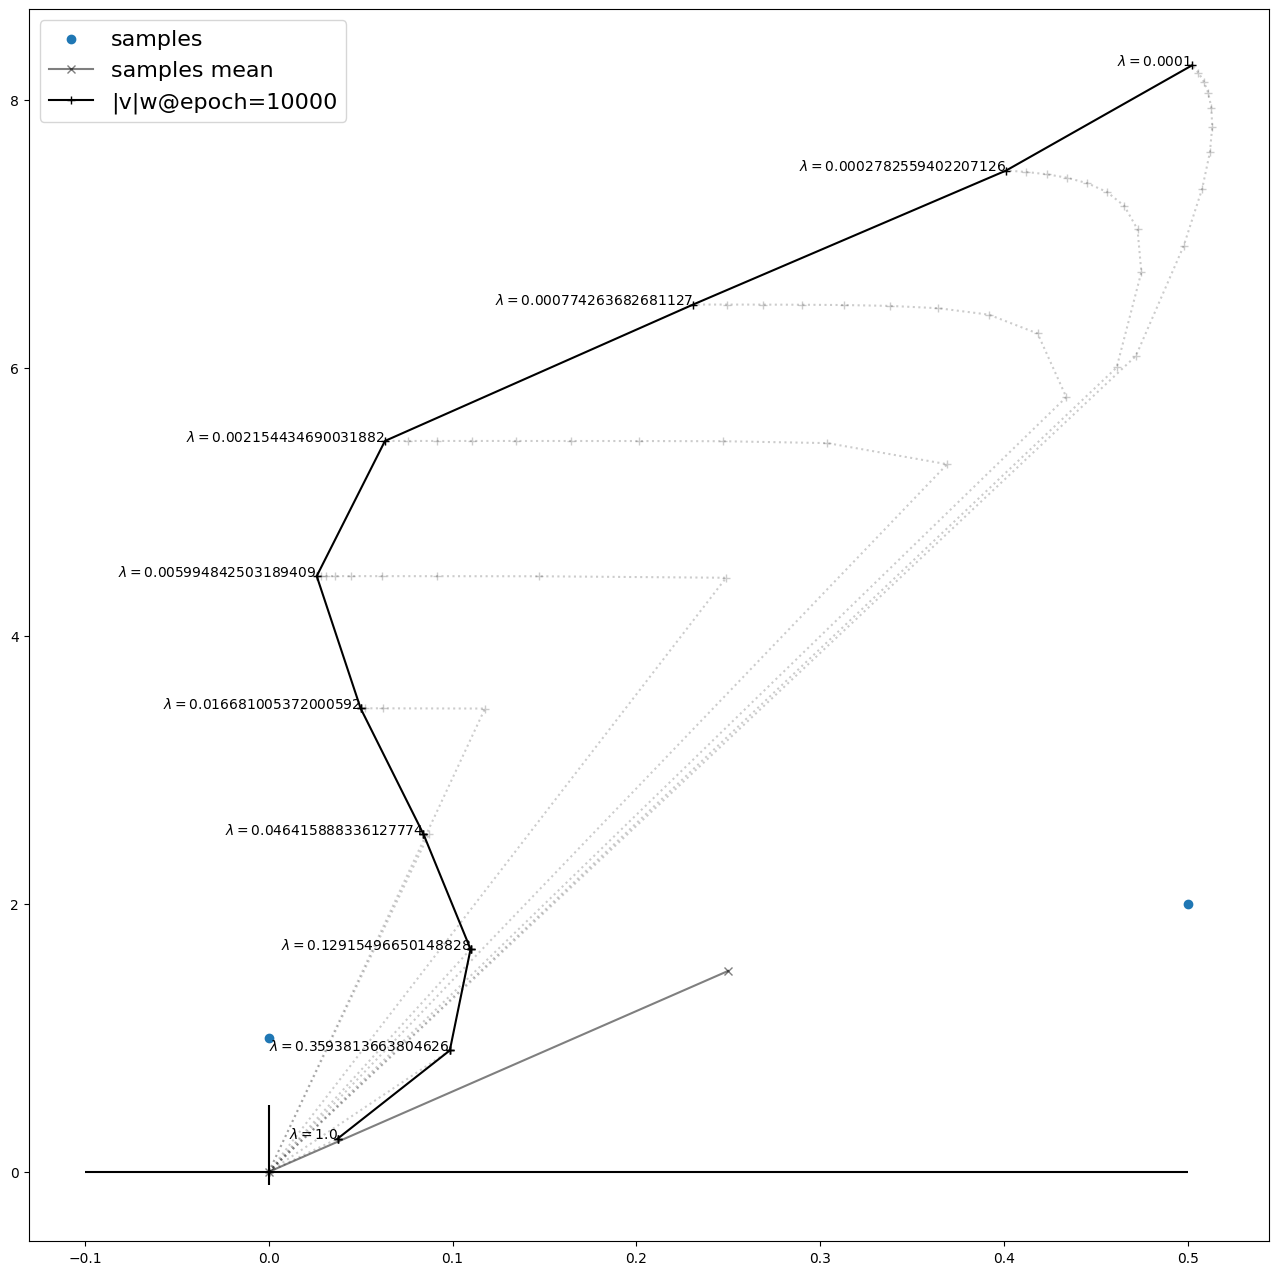

In [28]:
import matplotlib.pyplot 

fig, ax = matplotlib.pyplot.subplots(figsize=(16, 16))

with torch.no_grad():
    ax_lim = 2
    ax.scatter(inputs[:, 0], inputs[:, 1], label='samples')
    ax.plot([0, inputs[:, 0].mean().item()], [0, inputs[:, 1].mean().item()], label='samples mean', marker='x', c='k', alpha=.5)

    for regularization, iterates in zip(regularization_values, regularization_iterates):
        ax.plot(iterates[:, 0], iterates[:, 1], linestyle=':', color='k', marker='+', alpha=0.2, **({} if regularization == regularization_values[-1] else {'label': 'intermidiate |v|w'}))
        ax.text(iterates[-1, 0], iterates[-1, 1], f'$\\lambda = {regularization:.4f}$', ha='right')


    ax.plot(regularization_iterates[:, -1, 0], regularization_iterates[:, -1, 1], 
                     linestyle='-', color='black', marker='+', label=f'|v|w@epoch={experiment["epochs"]}')
    
    #args = dict(alpha = 0.2, c='b')
    #for index, (regularization, final_iterate_x, final_iterate_y) in enumerate(zip(regularization_values, regularization_iterates[:, -1, 0], regularization_iterates[:, -1, 1])):
    #    norm = (final_iterate_x ** 2 + final_iterate_y ** 2) ** .5
    #    final_iterate_x, final_iterate_y = final_iterate_x / norm, final_iterate_y / norm
#
    #    if index == len(regularization_values) - 1: args.update(label=f'w/\\||\\|@epoch={experiment["epochs"]}')
    #    
    #    ax.plot([0, final_iterate_x], [0, final_iterate_y], **args)

    ax.legend(prop={'size': 16})
    ax.hlines(0, -.1, .5, color='black', zorder=1)
    ax.vlines(0, -.1, .5, color='black', zorder=1)
    
    fig


# Legacy

In [ ]:
#regularization_values = numpy.logspace(-8, -1, num=10)    # [0.001]
regularization_values = [0.0001, 0.001, 0.01, 0.1]
regularized_solutions = []
for regularization in regularization_values:
    experiment_stage1_result, model, device, generator = execute_experiment(
        **{**experiment, 'regularization': regularization},
        train_data=train_data, 
        test_data=test_data, 
        model_class=FullyConnectedNeuralNetwork,
        train_loss_class=train_loss,
        callbacks_epochs=list(range(0, experiment['epochs'], experiment['epochs'])),
        overwrite=True,
        callbacks=[
                #plot_angle_linesearch_, 
                #plot_changes_in_directions_,
                ##plot_weights_norms_, 
                #plot_train_loss_,
                #plot_loss_gradient_inner_product_to_norm_ratio_,
                ##plot_unique_neuron_angles_,
                #plot_samples_and_neurons_,
                #draw_figure_into_canvas_, 
                #save_figure_
        ],
        train_data_callbacks=[model_summary]
    )
    regularization_solution = model.norms * (model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1))
    regularized_solutions.append(regularization_solution[0].detach().cpu().numpy())

regularized_solutions = numpy.array(regularized_solutions)

In [ ]:

epochs = list(range(0, experiment['epochs'], 1000)) + [experiment['epochs']]
unregularized_solutions = []
early_stopped_regularized_solutions = []

def optimize_magnitude(model, *args, **experiment):
    regularization = 0.01
    signed_labels = (labels * 2. - 1.).unsqueeze(1).detach().cpu().numpy()
    #predictions = model(inputs)
    neurons_norms = model.norms.detach().cpu().numpy()
    neurons_normalized_weights = model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1)
    neurons_sign = model.neurons_sign.detach().cpu().numpy()
    normalized_predictions = neurons_sign * torch.relu(inputs @ neurons_normalized_weights.T).detach().cpu().numpy()
    normalized_margins = signed_labels * normalized_predictions
    num_neurons = len(neurons_norms)
    new_model = FullyConnectedNeuralNetwork(**experiment)
    with torch.no_grad():
        new_model.input_layer.weight.copy_(model.input_layer.weight)
        new_model.output_layer.weight.copy_(model.output_layer.weight)

    new_model = MagnitudeOptimizer(new_model, new_model.device)
    # Construct the problem.
    alpha = cvxpy.Variable(num_neurons, nonneg=True)
    alpha.value = neurons_norms
    objective = cvxpy.Minimize(cvxpy.sum(cvxpy.exp(- normalized_margins @ alpha)) / experiment['sample_size'] + regularization * cvxpy.norm(alpha, 1))
    problem = cvxpy.Problem(objective)

    # The optimal objective value is returned by `prob.solve()`.
    result = problem.solve(warm_start=True,
        tol_gap_abs=1e-14,
        tol_gap_rel=1e-14,
        tol_feas=1e-14,
        tol_infeas_abs=1e-14,
        tol_infeas_rel=1e-14,
        tol_ktratio=1e-14,
    )
    
    # The optimal value for x is stored in `x.value`.
    #print(alpha.value)
    #print(problem.status)
    alpha_star = numpy.where(alpha.value >= 1e-14, alpha.value, 0.) # projection operator

    with torch.no_grad():
        new_model.output_layer.weight.copy_(torch.tensor(alpha_star))

    early_stopped_regularized_solutions.append((new_model.norms * (new_model.input_layer.weight / new_model.input_layer.weight.norm(dim=1).unsqueeze(1)))[0].detach().cpu().numpy())

experiment_stage1_result, model, device, generator = execute_experiment(
    **{**experiment},
    train_data=train_data, 
    test_data=test_data, 
    model_class=FullyConnectedNeuralNetwork,
    train_loss_class=train_loss,
    callbacks_epochs=epochs,
    overwrite=True,
    callbacks=[
            lambda model, *args, **kwargs: unregularized_solutions.append((model.norms * (model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1)))[0].detach().cpu().numpy()),
            optimize_magnitude,
            #plot_angle_linesearch_, 
            #plot_changes_in_directions_,
            ##plot_weights_norms_, 
            #plot_train_loss_,
            #plot_loss_gradient_inner_product_to_norm_ratio_,
            ##plot_unique_neuron_angles_,
            #plot_samples_and_neurons_,
            #draw_figure_into_canvas_, 
            #save_figure_
    ],
    train_data_callbacks=[model_summary_]
)
unregularized_solutions = numpy.array(unregularized_solutions)

In [4]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function
def objective(xy):
    x, y = xy
    return x**2 + 2*y**2 + 2.2*x*y

# Define the constraints
constraints = [
    {'type': 'ineq', 'fun': lambda xy: xy[0] + 1.1 * xy[1] - 1},  # x + y >= 1
    {'type': 'ineq', 'fun': lambda xy: 2*xy[1] + 1.1* xy[0] - 1} # 2y + x >= 1
]

# Initial guess
x0 = [0, 0]

# Solve the optimization problem
result = minimize(objective, x0, constraints=constraints, method='SLSQP')

# Print results
print("Optimal solution (x, y):", result.x)
print("Optimal value of the objective function:", result.fun)


Optimal solution (x, y): [ 1.00000002e+00 -1.88168679e-08]
Optimal value of the objective function: 0.9999999992322924


In [ ]:

signed_labels = (labels * 2. - 1.).unsqueeze(1).detach().cpu().numpy()
#predictions = model(inputs)
neurons_norms = model.norms.detach().cpu().numpy()
neurons_normalized_weights = model.input_layer.weight / model.input_layer.weight.norm(dim=1).unsqueeze(1)
neurons_sign = model.neurons_sign.detach().cpu().numpy()
normalized_predictions = neurons_sign * torch.relu(inputs @ neurons_normalized_weights.T).detach().cpu().numpy()
normalized_margins = signed_labels * normalized_predictions
num_neurons = len(neurons_norms)
new_model = FullyConnectedNeuralNetwork(**experiment)
with torch.no_grad():
    new_model.input_layer.weight.copy_(model.input_layer.weight)
    new_model.output_layer.weight.copy_(model.output_layer.weight)

new_model = MagnitudeOptimizer(new_model, new_model.device)
train_loss_instance = train_loss()
magnitude_optimizations_results = []
for regularization in tqdm.tqdm(regularization_values):
    # Construct the problem.
    alpha = cvxpy.Variable(num_neurons, nonneg=True)
    alpha.value = neurons_norms
    objective = cvxpy.Minimize(cvxpy.sum(cvxpy.exp(- normalized_margins @ alpha)) / experiment['sample_size'] + regularization * cvxpy.norm(alpha, 1))
    problem = cvxpy.Problem(objective)

    # The optimal objective value is returned by `prob.solve()`.
    result = problem.solve(warm_start=True,
        tol_gap_abs=1e-14,
        tol_gap_rel=1e-14,
        tol_feas=1e-14,
        tol_infeas_abs=1e-14,
        tol_infeas_rel=1e-14,
        tol_ktratio=1e-14,
    )
        
    # The optimal value for x is stored in `x.value`.
    #print(alpha.value)
    #print(problem.status)
    alpha_star = numpy.where(alpha.value >= 1e-14, alpha.value, 0.) # projection operator

    with torch.no_grad():
        new_model.output_layer.weight.copy_(torch.tensor(alpha_star))

    predictions = new_model(inputs)
    #margins = signed_labels * predictions
    #signed_labels * torch.exp(-margins) * (inputs @ )
    #with torch.no_grad():
    #    new_model.output_layer.weight.copy_(torch.tensor(alpha.value))
    experiment_stage2 = {**copy.deepcopy(experiment_stage1_result), 'epoch': 1001, 'id': 'kkt_points_regularized', 'regularization': regularization}
    for callback in [
        model_summary_,
        plot_angle_linesearch_, 
        plot_changes_in_directions_,
        #plot_unique_neuron_angles_,
        #plot_weights_norms_, 
        plot_loss_gradient_inner_product_to_norm_ratio_,
        plot_samples_and_neurons_,
        lambda test_data, model, **experiment: experiment_stage2['test_loss'].append(test(test_data, model, train_loss_instance, model.device, **experiment)),
        lambda train_data, model, **experiment: experiment_stage2['train_loss'].append(test(train_data, model, train_loss_instance, model.device, **experiment)),
        plot_train_loss_,
        draw_figure_into_canvas_,
        save_figure_
    ]:
        callback(model=new_model, train_data=train_data, test_data=test_data, labels=labels, predictions=predictions, **experiment_stage2)

    magnitude_optimizations_results.append(experiment_stage2['model_metrics'][-1])

variances_results.append(magnitude_optimizations_results)